In [375]:
# Data wrangling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import statsmodels.api as sm

# Enriching (extra)
import tmdbsimple as tmdb # Wrapper library for the API of themoviedb.org  (TMDB)
from tqdm import tqdm # Progress bar for the script
from datetime import datetime # Used for dates 
from dotenv import load_dotenv # Makes keeping the API-key as local environment file simpler
import os # Used for loading the .env file

# NLP (extra)
import re
import json
import nltk
import pickle
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import spacy
from sklearn.metrics import silhouette_score
from sklearn.decomposition import TruncatedSVD
from nltk.stem import PorterStemmer
nltk.download('punkt')
nltk.download('stopwords')
from wordcloud import WordCloud



# Enriching data
#### 1. Adding data from www.themoviedb.org (TMDB)


In this section we are going to be using the API of www.themoviedb.org (TMDB) to populate the existing dataframe with more information about the movie. The script (TMDB_v1) will query the website using the movie name to find the closest match based on the movie's release date. If no match is found, it skips the movie and moves on to the next one.

This 1. step is adding a lot of different data from TMDB. The most important features are the:
- TMDB ID           (unique identifier for the movie, which can be used to further enrich the data)
- TMDB vote average (average movie rating)
- TMDB vote count   (how many votes were cast)

Furthermore, TMDB_v1 also adds the:
- original language, original title, release date, title
- overview (summary)
- popularity (metric composed of many different variables indicating a movies lifetime popularity)


This script was run separately in another file in /utils/add_TMDB_movie_metadata_v1.py as it needed to be executed in  several installments over several sessions, since the API was limited by 40 requests/second. (this version contains slightly different path variations).

In [2]:
load_dotenv() # Loads .env files aka. the TMDB_API_KEY

headers_movie_metadata = ["Wikipedia Movie ID", "Freebase Movie ID", "Movie name", "Movie release date",
                          "Movie box office revenue", "Movie runtime", "Movie languages", "Movie countries",
                          "Movie genres"]
movie_metadata = pd.read_csv('data/movie.metadata.tsv', sep="\t", names=headers_movie_metadata)


# Load API key
TMDB_API_KEY = os.environ.get("TMDB_API_KEY")
tmdb.API_KEY = TMDB_API_KEY
tmdb.REQUESTS_TIMEOUT = 5  # Seconds, for both connect and read

# Create a list to save progress
saved_progress = []

# Determine where to resume
start_index = 28000

# Progress file that can be used to resume
#saved_progress = pd.read_json('progress.json')['index'].tolist()
#start_index = saved_progress[-1] + 1  # Start from the next index

# Create a DataFrame to store the data
movie_metadata_TMDB = movie_metadata.copy()

for index, row in tqdm(movie_metadata_TMDB.iterrows(), total=len(movie_metadata_TMDB), desc="Processing"): # Wraps for loop in progress bar.
    
    # Skip previously processed indices - Commented out in favor of manual start_index
    #if index in saved_progress:
    #    continue
    if index < start_index:
        continue
    try:
        if not pd.isna(row["Movie release date"]):
            search = tmdb.Search()
            response = search.movie(query=row["Movie name"])

            # Convert dataframe release date to datetime
            movie_release_date_str = row["Movie release date"]
            if len(movie_release_date_str) == 4:  # Handle "YYYY" format
                movie_release_date = datetime.strptime(movie_release_date_str, "%Y").date()
            elif len(movie_release_date_str) == 7:  # Handle "YYYY-DD" format
                movie_release_date = datetime.strptime(movie_release_date_str, "%Y-%m").date()
            else:  # Assume it's in the format "YYYY-MM-DD"
                movie_release_date = datetime.strptime(movie_release_date_str, "%Y-%m-%d").date()

            # Handle if release_date is empty.
            date_list_converted = [datetime.strptime(each_date['release_date'], "%Y-%m-%d").date() for each_date in
                                   search.results if each_date.get('release_date')]

            # Create list of differences in time
            differences = [abs(movie_release_date - each_date) for each_date in date_list_converted]
            
            # If differences are empty = skip
            if not differences:
                continue
            minimum_index = differences.index(min(differences))  # Index of the closest match
            match = search.results[minimum_index]
            # print(f"Closest match: {match['title']} (Release Date: {match['release_date']})")

            # Add info in dataframe about the movie
            movie_metadata_TMDB.loc[index, 'TMDB_id'] = match['id']
            movie_metadata_TMDB.loc[index, 'TMDB_original_language'] = match['original_language']
            movie_metadata_TMDB.loc[index, 'TMDB_original_title'] = match['original_title']
            movie_metadata_TMDB.loc[index, 'TMDB_overview'] = match['overview']
            movie_metadata_TMDB.loc[index, 'TMDB_popularity'] = match['popularity']
            movie_metadata_TMDB.loc[index, 'TMDB_release_date'] = match['release_date']
            movie_metadata_TMDB.loc[index, 'TMDB_title'] = match['title']
            movie_metadata_TMDB.loc[index, 'TMDB_vote_average'] = match['vote_average']
            movie_metadata_TMDB.loc[index, 'TMDB_vote_count'] = match['vote_count']
            
            # Save the index as progress
            saved_progress.append(index)

            # Save progress periodically (in case of interruption)
            if index % 50 == 0:
                progress_df = pd.DataFrame({'index': saved_progress})
                progress_df.to_json('progress.json')
                movie_metadata_TMDB.to_csv('movie_metadata_TMDB.csv', index=False)

    except Exception as e:
        print(f"Error at index {index}: {str(e)}")

# Save final progress
progress_df = pd.DataFrame({'index': saved_progress})
progress_df.to_json('progress.json')

# Save your final DataFrame
#movie_metadata_TMDB.to_csv('modified_data/movie_metadata_TMDB.csv') # Commented out to not overwrite existing file with blank data

Processing: 100%|██████████| 81741/81741 [00:03<00:00, 20657.45it/s]


We are now going to see how many rows of data were populated in the enriching. 
The TMDB_ID is a good indicator for this.

In [3]:
df = pd.read_csv('modified_data/movie_metadata_TMDB.csv')
print(f"Added TMDB ID to {df['TMDB_id'].count()} movies. Total movies: {df['Wikipedia Movie ID'].count()}. \n Percentage populated: {round(df['TMDB_id'].count()/df['Wikipedia Movie ID'].count()*100,2)}%")


Added TMDB ID to 68944 movies. Total movies: 81741. 
 Percentage populated: 84.34%


#### 2. Adding Movie Revenue
The script above (TMDB_v1) used a 'query' method for TMDB, we are now going to be using the 'Movies' method to collect further data about the movies (TMDB_v2). 
Since many of the movies are missing their revenue, TMDB might have that information for some movies.

The same basis as for TMDB_v1 is used to collect data. The data being collected is: 
- revenue, budget, runtime, IMDB-id and genres.

While our original dataset includes movie genres, it's always good to have more information and the two might differ for an interesting analysis further on.

Like TMDB_v1, TMDB_v2 was run separately in another file: /utils/add_TMDB_movie_metadata_V2.py as it needed to be run on several occasions since the API is limited.

In [ ]:
load_dotenv()

# Load v1, which was created in TMDB_v1 above
movie_metadata_TMDB = pd.read_csv('modified_data/movie_metadata_TMDB.csv')
movie_metadata_TMDB = movie_metadata_TMDB.dropna(subset=['TMDB_id']) # Drop all columns, which don't contain an id

TMDB_API_KEY = os.environ.get("TMDB_API_KEY")
tmdb.API_KEY = TMDB_API_KEY
tmdb.REQUESTS_TIMEOUT = 5  

saved_progress = []
start_index = 35000

#saved_progress = pd.read_json('progress_v2.json')['index'].tolist()
#start_index = saved_progress[-1] + 1  # Start from the next index

for index, row in tqdm(movie_metadata_TMDB.iterrows(), total=len(movie_metadata_TMDB), desc="Processing"): 
    if index < start_index:
        continue
    try:
        movie = tmdb.Movies(row['TMDB_id']) # The "Movies" method is used with the TMDB_id of the movie
        movie_info = movie.info()
        
        # The dataframe is populated with the data: runtime, revenue, budget and IMDB_id.
        movie_metadata_TMDB.loc[index,'TMDB_runtime'] = movie_info['runtime']
        movie_metadata_TMDB.loc[index,'TMDB_revenue'] = movie_info['revenue']
        movie_metadata_TMDB.loc[index,'TMDB_budget'] = movie_info['budget']
        movie_metadata_TMDB.loc[index,'TMDB_IMDB_id'] = movie_info['imdb_id']

        # Convert list of genres to a string representation for adding the values easily to the df
        genres_str = ', '.join([genre['name'] for genre in movie_info['genres']])
        # Assign values to DataFrame
        movie_metadata_TMDB.loc[index, 'TMDB_genres'] = genres_str
        
        saved_progress.append(index)

        if index % 50 == 0:
            progress_df = pd.DataFrame({'index': saved_progress})
            progress_df.to_json('progress_v2.json')
            movie_metadata_TMDB.to_csv('movie_metadata_TMDB_v2.csv', index=False)

    except Exception as e:
        print(f"Error at index {index}: {str(e)}")

progress_df = pd.DataFrame({'index': saved_progress})
progress_df.to_json('progress_v2.json')

#movie_metadata_TMDB.to_csv('modified_data/movie_metadata_TMDB_v2_DONE.csv', index=False) # commented out to not overwrite existing data

After data collection we now need to merge the datasets created by TMDB_v2 and TMDB_v1. This merge is going to create a dataset called TMDB_v3. This is done to make sure we have a dataset that contains all the data and not only movies where a 'TMDB_id' is present as in TMDB_v2.


In [35]:
# The two datasets are loaded
movie_metadata_v2 = pd.read_csv('modified_data/movie_metadata_TMDB_v2.csv')
movie_metadata = pd.read_csv('modified_data/movie_metadata_TMDB.csv',index_col=0)

# Datasets are inspected beforehand
display(movie_metadata)
display(movie_metadata_v2)

# Datasets are merged with a left join on movie_metadata (the dataset we want to populate)
merged_df = pd.merge(movie_metadata,movie_metadata_v2,how='left')

display(merged_df) # The merged dataset is displayed and a successful merge is confirmed

merged_df.to_csv("modified_data/movie_metadata_TMDB_v3.csv",index=False) # The merged dataset is saved as *_V3 


C:\Users\gusta\AppData\Local\Temp\ipykernel_9244\688652978.py:2: DtypeWarning: Columns (21,22) have mixed types. Specify dtype option on import or set low_memory=False.
  movie_metadata_v2 = pd.read_csv('modified_data/movie_metadata_TMDB_v2.csv')


,Wikipedia Movie ID,Freebase Movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres,TMDB_id,TMDB_original_language,TMDB_original_title,TMDB_overview,TMDB_popularity,TMDB_release_date,TMDB_title,TMDB_vote_average,TMDB_vote_count
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",10016.0,en,Ghosts of Mars,"In 2176, a Martian police unit is sent to pick...",17.280,2001-08-24,Ghosts of Mars,5.123,980.0
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",784579.0,en,Getting Away with Murder: The JonBenét Ramsey ...,Dramatization of the story behind the murder o...,0.750,2000-02-16,Getting Away with Murder: The JonBenét Ramsey ...,8.000,1.0
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",396302.0,no,Brun bitter,A stolen bicycle case ends with drunken detect...,0.600,1988-11-17,Hair of the Dog,0.000,0.0
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",33592.0,en,White of the Eye,"In a wealthy and isolated desert community, a ...",7.336,1987-06-19,White of the Eye,5.742,64.0
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",11192.0,de,Die flambierte Frau,"Eva, an upper-class housewife, frustratedly le...",2.397,1983-05-11,A Woman in Flames,5.300,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81736,35228177,/m/0j7hxnt,Mermaids: The Body Found,2011-03-19,NaN,120.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama""}",117124.0,en,Mermaids: The Body Found,A story that imagines how these real-world phe...,5.098,2011-03-19,Mermaids: The Body Found,4.500,20.0
81737,34980460,/m/0g4pl34,Knuckle,2011-01-21,NaN,96.0,"{""/m/02h40lc"": ""English Language""}","{""/m/03rt9"": ""Ireland"", ""/m/07ssc"": ""United Ki...","{""/m/03bxz7"": ""Biographical film"", ""/m/07s9rl0...",44946.0,en,Knucklehead,A fight promoter deeply in debt to his crooked...,9.789,2010-10-22,Knucklehead,5.500,50.0
81738,9971909,/m/02pygw1,Another Nice Mess,1972-09-22,NaN,66.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06nbt"": ""Satire"", ""/m/01z4y"": ""Comedy""}",285337.0,en,Another Nice Mess,Nixon and Agnew played as Laurel and Hardy.,1.960,1972-08-23,Another Nice Mess,0.000,0.0
81739,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,1992-05-21,NaN,150.0,"{""/m/03_9r"": ""Japanese Language""}","{""/m/03_3d"": ""Japan""}","{""/m/06n90"": ""Science Fiction"", ""/m/0gw5n2f"": ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,Wikipedia Movie ID,Freebase Movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres,TMDB_id,...,TMDB_popularity,TMDB_release_date,TMDB_title,TMDB_vote_average,TMDB_vote_count,TMDB_runtime,TMDB_revenue,TMDB_budget,TMDB_IMDB_id,TMDB_genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",10016.0,...,17.280,2001-08-24,Ghosts of Mars,5.123,980.0,98.0,14010832.0,28000000.0,tt0228333,"Action, Horror, Science Fiction"
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",784579.0,...,0.750,2000-02-16,Getting Away with Murder: The JonBenét Ramsey ...,8.000,1.0,60.0,NaN,0.0,tt0245916,"Drama, Crime"
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",396302.0,...,0.600,1988-11-17,Hair of the Dog,0.000,0.0,83.0,NaN,0.0,tt0094806,"Mystery, Crime, Drama"
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",33592.0,...,7.336,1987-06-19,White of the Eye,5.742,64.0,111.0,NaN,0.0,tt0094320,"Horror, Thriller"
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",11192.0,...,2.397,1983-05-11,A Woman in Flames,5.300,13.0,106.0,NaN,0.0,tt0083949,Drama
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68939,32468537,/m/0crwd9y,Shadow Boxing 2,2007-10-18,NaN,132.0,"{""/m/06b_j"": ""Russian Language"", ""/m/02h40lc"":...","{""/m/06bnz"": ""Russia""}","{""/m/01z02hx"": ""Sports"", ""/m/0lsxr"": ""Crime Fi...",56525.0,...,4.421,2007-10-18,Revenge,5.607,28.0,NaN,NaN,NaN,NaN,NaN
68940,35228177,/m/0j7hxnt,Mermaids: The Body Found,2011-03-19,NaN,120.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama""}",117124.0,...,5.098,2011-03-19,Mermaids: The Body Found,4.500,20.0,NaN,NaN,NaN,NaN,NaN
68941,34980460,/m/0g4pl34,Knuckle,2011-01-21,NaN,96.0,"{""/m/02h40lc"": ""English Language""}","{""/m/03rt9"": ""Ireland"", ""/m/07ssc"": ""United Ki...","{""/m/03bxz7"": ""Biographical film"", ""/m/07s9rl0...",44946.0,...,9.789,2010-10-22,Knucklehead,5.500,50.0,NaN,NaN,NaN,NaN,NaN
68942,9971909,/m/02pygw1,Another Nice Mess,1972-09-22,NaN,66.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06nbt"": ""Satire"", ""/m/01z4y"": ""Comedy""}",285337.0,...,1.960,1972-08-23,Another Nice Mess,0.000,0.0,NaN,NaN,NaN,NaN,NaN


,Wikipedia Movie ID,Freebase Movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres,TMDB_id,...,TMDB_popularity,TMDB_release_date,TMDB_title,TMDB_vote_average,TMDB_vote_count,TMDB_runtime,TMDB_revenue,TMDB_budget,TMDB_IMDB_id,TMDB_genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",10016.0,...,17.280,2001-08-24,Ghosts of Mars,5.123,980.0,98.0,14010832.0,28000000.0,tt0228333,"Action, Horror, Science Fiction"
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",784579.0,...,0.750,2000-02-16,Getting Away with Murder: The JonBenét Ramsey ...,8.000,1.0,60.0,NaN,0.0,tt0245916,"Drama, Crime"
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",396302.0,...,0.600,1988-11-17,Hair of the Dog,0.000,0.0,83.0,NaN,0.0,tt0094806,"Mystery, Crime, Drama"
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",33592.0,...,7.336,1987-06-19,White of the Eye,5.742,64.0,111.0,NaN,0.0,tt0094320,"Horror, Thriller"
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",11192.0,...,2.397,1983-05-11,A Woman in Flames,5.300,13.0,106.0,NaN,0.0,tt0083949,Drama
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81736,35228177,/m/0j7hxnt,Mermaids: The Body Found,2011-03-19,NaN,120.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama""}",117124.0,...,5.098,2011-03-19,Mermaids: The Body Found,4.500,20.0,NaN,NaN,NaN,NaN,NaN
81737,34980460,/m/0g4pl34,Knuckle,2011-01-21,NaN,96.0,"{""/m/02h40lc"": ""English Language""}","{""/m/03rt9"": ""Ireland"", ""/m/07ssc"": ""United Ki...","{""/m/03bxz7"": ""Biographical film"", ""/m/07s9rl0...",44946.0,...,9.789,2010-10-22,Knucklehead,5.500,50.0,NaN,NaN,NaN,NaN,NaN
81738,9971909,/m/02pygw1,Another Nice Mess,1972-09-22,NaN,66.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06nbt"": ""Satire"", ""/m/01z4y"": ""Comedy""}",285337.0,...,1.960,1972-08-23,Another Nice Mess,0.000,0.0,NaN,NaN,NaN,NaN,NaN
81739,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,1992-05-21,NaN,150.0,"{""/m/03_9r"": ""Japanese Language""}","{""/m/03_3d"": ""Japan""}","{""/m/06n90"": ""Science Fiction"", ""/m/0gw5n2f"": ...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##### 2.1 Combining revenue columns into a single one.
In this section we're going to analyse the data collected, combine the 'original revenue' and 'TMDB_revenue' columns and save another version of the dataset, which contains the final data for the analysis.

In [39]:
movie_metadata_v3 = pd.read_csv('modified_data/movie_metadata_TMDB_v3.csv')

# We will now compare the two columns containing the 'original revenue' and 'TMDB_revenue', where either column is NaN but not both at the same time. This will show how they can complement each other.
filtered_df = movie_metadata_v3[(movie_metadata_v3['Movie box office revenue'].isna() | movie_metadata_v3['TMDB_revenue'].isna()) & ~(movie_metadata_v3['Movie box office revenue'].isna() & movie_metadata_v3['TMDB_revenue'].isna())]
display(filtered_df[['Movie name','Movie box office revenue','TMDB_revenue']])

# Combining the two revenue columns into one using combine_first which combines two df objects by filling null values in one df with non-null from the other df 
movie_metadata_v3['Movie box office revenue enriched'] = movie_metadata_v3['Movie box office revenue'].combine_first(movie_metadata_v3['TMDB_revenue'])

# Comparing old dataset to new
tmdb_v3_revenue = movie_metadata_v3['Movie box office revenue enriched'].isna().sum()
tmdb_v1 = pd.read_csv('modified_data/movie_metadata_TMDB.csv')
tmdb_v1_revenue = tmdb_v1['Movie box office revenue'].isna().sum()

print("Original revenue NaN:", tmdb_v1_revenue)
print("New revenue NaN:",tmdb_v3_revenue)
print("Difference", tmdb_v1_revenue-tmdb_v3_revenue)

# Removing the two columns that combined into one column
movie_metadata_v4 = movie_metadata_v3.drop(columns=['Movie box office revenue','TMDB_revenue'])

display(movie_metadata_v4)

movie_metadata_v4.to_csv('modified_data/movie_metadata_TMDB_FINAL.csv',index=False) # Saving the final version of the modified dataset

C:\Users\gusta\AppData\Local\Temp\ipykernel_9244\2197755176.py:4: DtypeWarning: Columns (21,22) have mixed types. Specify dtype option on import or set low_memory=False.
  movie_metadata_v3 = pd.read_csv('modified_data/movie_metadata_TMDB_v3.csv')


,Movie name,Movie box office revenue,TMDB_revenue
36,They Knew What They Wanted,932000.0,NaN
47,Daddy and Them,NaN,6718.0
53,Rudo y Cursi,11091868.0,NaN
57,Innocence,NaN,37598.0
60,The Great New Wonderful,172055.0,NaN
...,...,...,...
81695,Coming to America,288752301.0,NaN
81720,Spaced Invaders,15369573.0,NaN
81725,State and Main,6944471.0,NaN
81726,Guilty as Sin,22886222.0,NaN


Original revenue NaN: 73340
New revenue NaN: 71723
Difference 1617


,Wikipedia Movie ID,Freebase Movie ID,Movie name,Movie release date,Movie runtime,Movie languages,Movie countries,Movie genres,TMDB_id,TMDB_original_language,...,TMDB_popularity,TMDB_release_date,TMDB_title,TMDB_vote_average,TMDB_vote_count,TMDB_runtime,TMDB_budget,TMDB_IMDB_id,TMDB_genres,Movie box office revenue enriched
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",10016.0,en,...,17.280,2001-08-24,Ghosts of Mars,5.123,980.0,98.0,28000000.0,tt0228333,"Action, Horror, Science Fiction",14010832.0
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",784579.0,en,...,0.750,2000-02-16,Getting Away with Murder: The JonBenét Ramsey ...,8.000,1.0,60.0,0.0,tt0245916,"Drama, Crime",NaN
2,28463795,/m/0crgdbh,Brun bitter,1988,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",396302.0,no,...,0.600,1988-11-17,Hair of the Dog,0.000,0.0,83.0,0.0,tt0094806,"Mystery, Crime, Drama",NaN
3,9363483,/m/0285_cd,White Of The Eye,1987,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",33592.0,en,...,7.336,1987-06-19,White of the Eye,5.742,64.0,111.0,0.0,tt0094320,"Horror, Thriller",NaN
4,261236,/m/01mrr1,A Woman in Flames,1983,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",11192.0,de,...,2.397,1983-05-11,A Woman in Flames,5.300,13.0,106.0,0.0,tt0083949,Drama,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81736,35228177,/m/0j7hxnt,Mermaids: The Body Found,2011-03-19,120.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama""}",117124.0,en,...,5.098,2011-03-19,Mermaids: The Body Found,4.500,20.0,NaN,NaN,NaN,NaN,NaN
81737,34980460,/m/0g4pl34,Knuckle,2011-01-21,96.0,"{""/m/02h40lc"": ""English Language""}","{""/m/03rt9"": ""Ireland"", ""/m/07ssc"": ""United Ki...","{""/m/03bxz7"": ""Biographical film"", ""/m/07s9rl0...",44946.0,en,...,9.789,2010-10-22,Knucklehead,5.500,50.0,NaN,NaN,NaN,NaN,NaN
81738,9971909,/m/02pygw1,Another Nice Mess,1972-09-22,66.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06nbt"": ""Satire"", ""/m/01z4y"": ""Comedy""}",285337.0,en,...,1.960,1972-08-23,Another Nice Mess,0.000,0.0,NaN,NaN,NaN,NaN,NaN
81739,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,1992-05-21,150.0,"{""/m/03_9r"": ""Japanese Language""}","{""/m/03_3d"": ""Japan""}","{""/m/06n90"": ""Science Fiction"", ""/m/0gw5n2f"": ...",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


It seems like the original dataset contained much of the information on the different movie revenues available.
However, for 1617 movies the revenue was added, which is quite a lot in the context of ~40000 movies with plot summaries. 
This will only further enhance the data analysis process.


# Data wrangling and exploration

We begin by loading the two data sets and looking at the different attributes. We decide to add two columns **Movie release year** and **Actor birth year**.

In [2]:
# Load datasets
headers_character_metadata = ['Wikipedia Movie ID', 'Freebase Movie ID','Movie release date', 'Character name', 'Actor DOB', 
                              'Actor gender', 'Actor height', 'Actor ethnicity', 'Actor name',
                              'Actor age at movie release', 'Freebase character map', 'Freebase character ID', 'Freebase actor ID']
character_metadata = pd.read_csv('./data/character.metadata.tsv', sep='\t', names=headers_character_metadata)

movie_metadata = pd.read_csv('./modified_data/movie_metadata_TMDB_FINAL.csv', sep=',')

/var/folders/j2/9f4vw4v96p97ssvk4f1301sw0000gn/T/ipykernel_61973/2220621918.py:7: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  movie_metadata = pd.read_csv('./modified_data/movie_metadata_TMDB_FINAL.csv', sep=',')


In [3]:
# Rename 'Movie box office revenue enriched' to Movie box office revenue' for to match previous column name
movie_metadata = movie_metadata.rename(columns={'Movie box office revenue enriched': 'Movie box office revenue'})

Since we are interested in **Movie box office revenue** and **TMDB_vote_avererage** (rating) we remove all the movies without that.

In [4]:
movie_metadata = movie_metadata[movie_metadata['Movie box office revenue'].notna()]
movie_metadata = movie_metadata[movie_metadata['TMDB_vote_average'].notna()]

We also only want to look at movies, that have a movie summary, since we will use this later for NLP.

In [5]:
# Extract movie IDs from the filtered DataFrame
movie_ids_filtered = movie_metadata['Wikipedia Movie ID'].tolist()

# Read file 'plot_summaries.txt'
with open('data/plot_summaries.txt', 'r', encoding='utf-8') as file:
    summaries = file.readlines()

# Filter summaries based on movie IDs that match with filtered_movie_ids
filtered_summaries = [summary for summary in summaries if int(summary.split()[0]) in movie_ids_filtered]

# Extract movie IDs for the films that with be used
movie_ids = [int(summary.split()[0]) for summary in filtered_summaries]

# Filter movie_metadata_filtered to include only rows with movie IDs present in movie_ids
movie_metadata = movie_metadata[movie_metadata['Wikipedia Movie ID'].isin(movie_ids)]

In [6]:
# Add a column of release year to get consistency
character_metadata['Movie release year'] = character_metadata['Movie release date'].str.split('-').str[0].astype('float')
movie_metadata['Movie release year'] = movie_metadata['Movie release date'].str.split('-').str[0].astype('float')

# Add a column of birth year to get consistency
character_metadata['Actor birth year'] = character_metadata['Actor DOB'].str.split('-').str[0].astype('float')


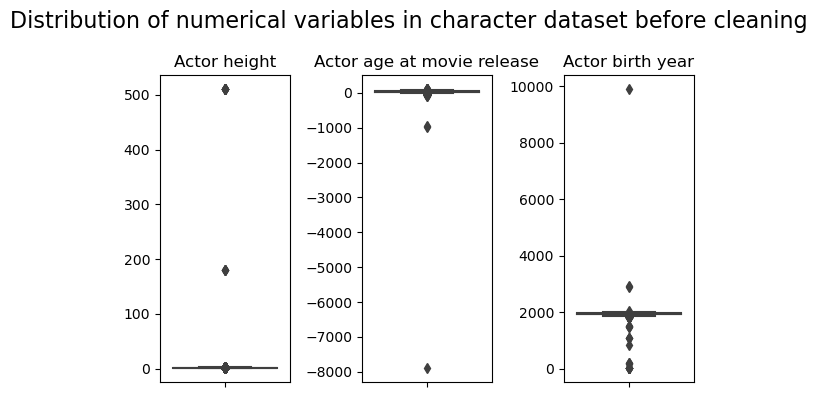

In [7]:
character_metadata_subset = character_metadata[['Actor height', 'Actor age at movie release', 'Actor birth year']]

# Set up subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(6, 4))
fig.suptitle('Distribution of numerical variables in character dataset before cleaning', fontsize=16)

# Flatten the axes for easier indexing
axes = axes.flatten()

# Iterate through each column and create a boxplot in a subplot
for i, column in enumerate(character_metadata_subset.columns):
    sns.boxplot(ax=axes[i], y=character_metadata_subset[column])
    axes[i].set_title(f'{column}')
    axes[i].set_ylabel('')

# Adjust layout
plt.tight_layout()
plt.savefig('figures/dist_and_clean/before_cleaning_character', dpi=1000, bbox_inches='tight')
plt.show()

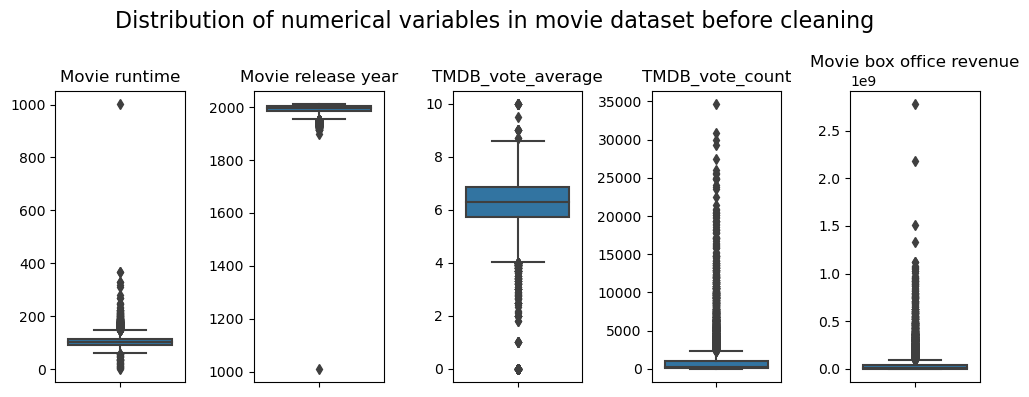

In [8]:
movie_metadata_subset = movie_metadata[['Movie runtime', 'Movie release year', 'TMDB_vote_average','TMDB_vote_count', 'Movie box office revenue']]

# Set up subplots
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(10, 4))
fig.suptitle('Distribution of numerical variables in movie dataset before cleaning', fontsize=16)

# Flatten the axes for easier indexing
axes = axes.flatten()

# Iterate through each column and create a boxplot in a subplot
for i, column in enumerate(movie_metadata_subset.columns):
    sns.boxplot(ax=axes[i], y=movie_metadata_subset[column])
    axes[i].set_title(f'{column}')
    axes[i].set_ylabel('')

# Adjust layout
plt.tight_layout()
plt.savefig('figures/dist_and_clean/before_cleaning_movie', dpi=1000, bbox_inches='tight')
plt.show()

## Remove outliers

### Character dataset

Now we look more closely at each attribute and remove unrealistic values. We first take a look at **Movie release year**:

In [9]:
# Define function that print the minimum and maximum values of a defines variable in the data frame
def get_min_and_max(df, variable_name, no_min, no_max):
    array = df[variable_name].fillna(0).unique()
    sorted_array = np.sort(array)
    
    min_values = sorted_array[:no_min]
    max_values = sorted_array[-no_max:]
    
    print(f"{no_min} minimum values of '{variable_name}':")
    print(min_values)
    print('\n')
    print(f"{no_max} maximum values of '{variable_name}':")
    print(max_values)


In [10]:
# Find all unique years as sort them
get_min_and_max(df=character_metadata, variable_name='Movie release year', no_min=5, no_max=5)

5 minimum values of 'Movie release year':
[   0. 1010. 1888. 1891. 1893.]


5 maximum values of 'Movie release year':
[2012. 2013. 2014. 2015. 2016.]


We remove values below year 1800.

In [11]:
condition1 = (character_metadata['Movie release year'] < 1800)
condition2 = (movie_metadata['Movie release year'] < 1800)

character_metadata.loc[condition1, 'Movie release year'] = np.nan
movie_metadata.loc[condition2, 'Movie release year'] = np.nan

We now take a look at **Actor birth year**:

In [12]:
get_min_and_max(df=character_metadata, variable_name='Actor birth year', no_min=15, no_max=5)

15 minimum values of 'Actor birth year':
[   0.   19.  183.  195.  852. 1075. 1474. 1498. 1796. 1804. 1828. 1829.
 1835. 1836. 1837.]


5 maximum values of 'Actor birth year':
[2011. 2050. 2896. 2936. 9900.]


We see, that some birth years are unrealistic and decide to remove birth years, that are below 1700 and above 2016 (last movie release year).

In [13]:
# Define the condition to identify rows where 'Actor birth year' needs to be set to NaN
condition = (character_metadata['Actor birth year'] < 1700) | (character_metadata['Actor birth year'] > 2016)
character_metadata.loc[condition, 'Actor birth year'] = np.nan

We now look at **Actor height**:

In [14]:
get_min_and_max(df=character_metadata, variable_name='Actor height', no_min=15, no_max=15)

15 minimum values of 'Actor height':
[0.      0.61    0.813   0.83    0.88    0.94    1.      1.06    1.067
 1.07    1.09728 1.1176  1.12    1.14    1.143  ]


15 maximum values of 'Actor height':
[  2.11      2.13      2.134     2.16      2.161     2.18      2.2
   2.24      2.28      2.29      2.31      2.31648   2.356   180.
 510.     ]


Again, we remove unrealistic values, which are people with a height more than 2.4 meter. The people with small heights are probably kids, but we leave these for now.

In [15]:
# Define the condition to identify rows where height needs to be set to NaN
condition = (character_metadata['Actor height'] > 2.4)
character_metadata.loc[condition, 'Actor height'] = np.nan

We now look at **Actor age at movie release**:

In [16]:
get_min_and_max(df=character_metadata, variable_name='Actor age at movie release', no_min=20, no_max=20)

20 minimum values of 'Actor age at movie release':
[-7896.  -969.  -937.   -81.   -76.   -65.   -63.   -57.   -53.   -51.
   -50.   -48.   -47.   -44.   -43.   -42.   -39.   -38.   -37.   -36.]


20 maximum values of 'Actor age at movie release':
[ 80.  81.  82.  83.  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.
  94.  95.  96.  97.  99. 103.]


We remove ages, that are less than 0 and higher than 110.

In [17]:
# Define the condition to identify rows where age needs to be set to NaN
condition = (character_metadata['Actor age at movie release'] < 0) | (character_metadata['Actor age at movie release'] > 110)
character_metadata.loc[condition, 'Actor age at movie release'] = np.nan

### Movie dataset

Let's begin by looking at **Movie runtime**:


In [18]:
# Fill missing values in 'Movie_runtime' with values from 'TMDB_runtime'
movie_metadata['Movie runtime'] = movie_metadata['Movie runtime'].fillna(movie_metadata['TMDB_runtime'])
movie_metadata['Movie runtime'].isna().sum()

37

In [19]:
get_min_and_max(df=movie_metadata, variable_name='Movie runtime', no_min=15, no_max=15)

15 minimum values of 'Movie runtime':
[ 0.   1.5  4.5  5.   6.  10.  12.  13.  16.  20.  21.  24.  25.  26.
 30. ]


15 maximum values of 'Movie runtime':
[ 224.  225.  231.  234.  246.  248.  250.  268.  269.  280.  312.  320.
  330.  366. 1003.]


We decide to only look at movies that have a maximum runtime of 500 minutes.

In [20]:
condition = (movie_metadata['Movie runtime'] > 500) | (movie_metadata['Movie runtime'] <= 0)
movie_metadata.loc[condition, 'Movie runtime'] = np.nan

Now let's take a look at **Movie box office revenue**:

In [21]:
get_min_and_max(df=movie_metadata, variable_name='Movie box office revenue', no_min=10, no_max=10)

10 minimum values of 'Movie box office revenue':
[ 1.  3. 10. 12. 13. 17. 18. 21. 25. 27.]


10 maximum values of 'Movie box office revenue':
[1.04387180e+09 1.06317191e+09 1.06565981e+09 1.07800895e+09
 1.11992952e+09 1.12374700e+09 1.32811122e+09 1.51175791e+09
 2.18537230e+09 2.78227517e+09]


As the box office revenue can have a huge span, and we don't have any negative values, we leave this for now.

In [22]:
get_min_and_max(df=movie_metadata, variable_name='TMDB_vote_count', no_min=10, no_max=10)

10 minimum values of 'TMDB_vote_count':
[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]


10 maximum values of 'TMDB_vote_count':
[24843. 24994. 25554. 25601. 26088. 27446. 29290. 29943. 30843. 34697.]


We see that a lot of movies have 0 vote counts and the data is heavily tailed. It does not make sense to include data for movies where the vote count is 0. We can first try get an overview over how much data we would loose if we filter out only the movies with 0 votes. Then we look at other cut-off values to get an overview. 

In [23]:
# Create a copy of the original DataFrame for comparison
original_df = movie_metadata.copy()

# Define a list of cutoff values to test
cutoff_values = [0, 1, 2, 4, 6, 8, 10, 20, 50]  # Add more values as needed

# Create a dictionary to store results
data_loss_results = {'Cutoff Value': [], 'Data Loss Percentage': [], 'Data Length': []}

# Iterate through cutoff values
for cutoff in cutoff_values:
    # Create a condition based on the cutoff
    condition = (original_df['TMDB_vote_count'] >= cutoff)
    
    # Apply the condition to filter the DataFrame
    filtered_df = original_df[condition]
    
    # Calculate the percentage of data loss
    data_loss_percentage = ((len(original_df) - len(filtered_df)) / len(original_df)) * 100
    data_length = len(filtered_df)

    # Append the results to the dictionary
    data_loss_results['Cutoff Value'].append(cutoff)
    data_loss_results['Data Loss Percentage'].append(data_loss_percentage)
    data_loss_results['Data Length'].append(data_length)

# Convert the results dictionary to a DataFrame for easier visualization
results_df = pd.DataFrame(data_loss_results)

# Print or visualize the results
results_df


,Cutoff Value,Data Loss Percentage,Data Length
0,0,0.000000,8674
1,1,1.302744,8561
2,2,2.005995,8500
3,4,3.331796,8385
4,6,4.565368,8278
5,8,6.075628,8147
6,10,7.320729,8039
7,20,12.808393,7563
8,50,23.991238,6593


In [24]:
condition = (movie_metadata['TMDB_vote_count'] >= 20)
movie_metadata = movie_metadata[condition]

## Transformation of skewed variables

The plots show, that **Movie box office** and **TMDB_vote_count** have a highly right skewed distribution, also called a power law. We would need to transform these attributes for further analysis.

The variable **Movie runtime** seem fairly normally distributed. The variable **Movie release year** is left skewed, so we will also try to apply a log transform to this.

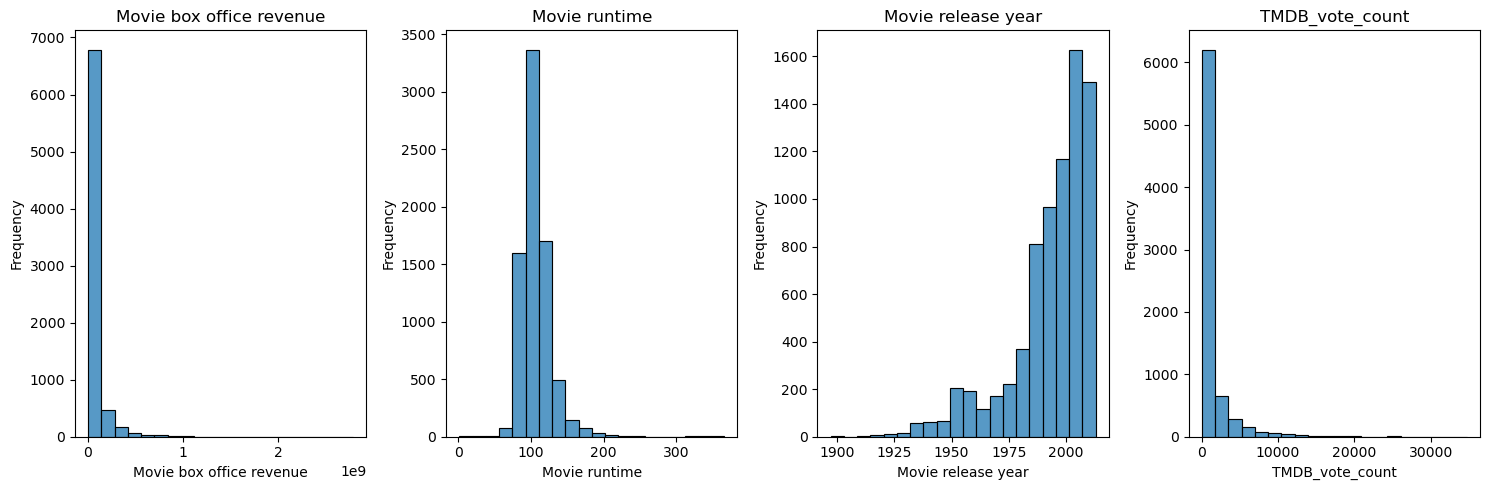

In [25]:
numerical_variables = ['Movie box office revenue', 'Movie runtime', 'Movie release year', 'TMDB_vote_count']

# Create a figure with four subplots (one for each variable)
fig, axes = plt.subplots(1, 4, figsize=(15, 5))

# Create histograms for each variable in each subplot
for i, variable in enumerate(numerical_variables):
    ax = axes[i]

    # Create histograms for female and male characters for the current variable
    sns.histplot(data=movie_metadata, x=variable, ax=ax, bins=20)

    ax.set_xlabel(variable)
    ax.set_ylabel('Frequency')
    ax.set_title(variable)

# Adjust the layout to prevent overlapping
plt.tight_layout()
plt.show()

After testing, we see that it only makes sense to transform **Movie box office revenue** and **TMDB_vote_count**.

In [26]:
movie_metadata['log Movie box office revenue'] = np.log(movie_metadata['Movie box office revenue'])

movie_metadata['log TMDB_vote_count'] = np.log(movie_metadata['TMDB_vote_count'])

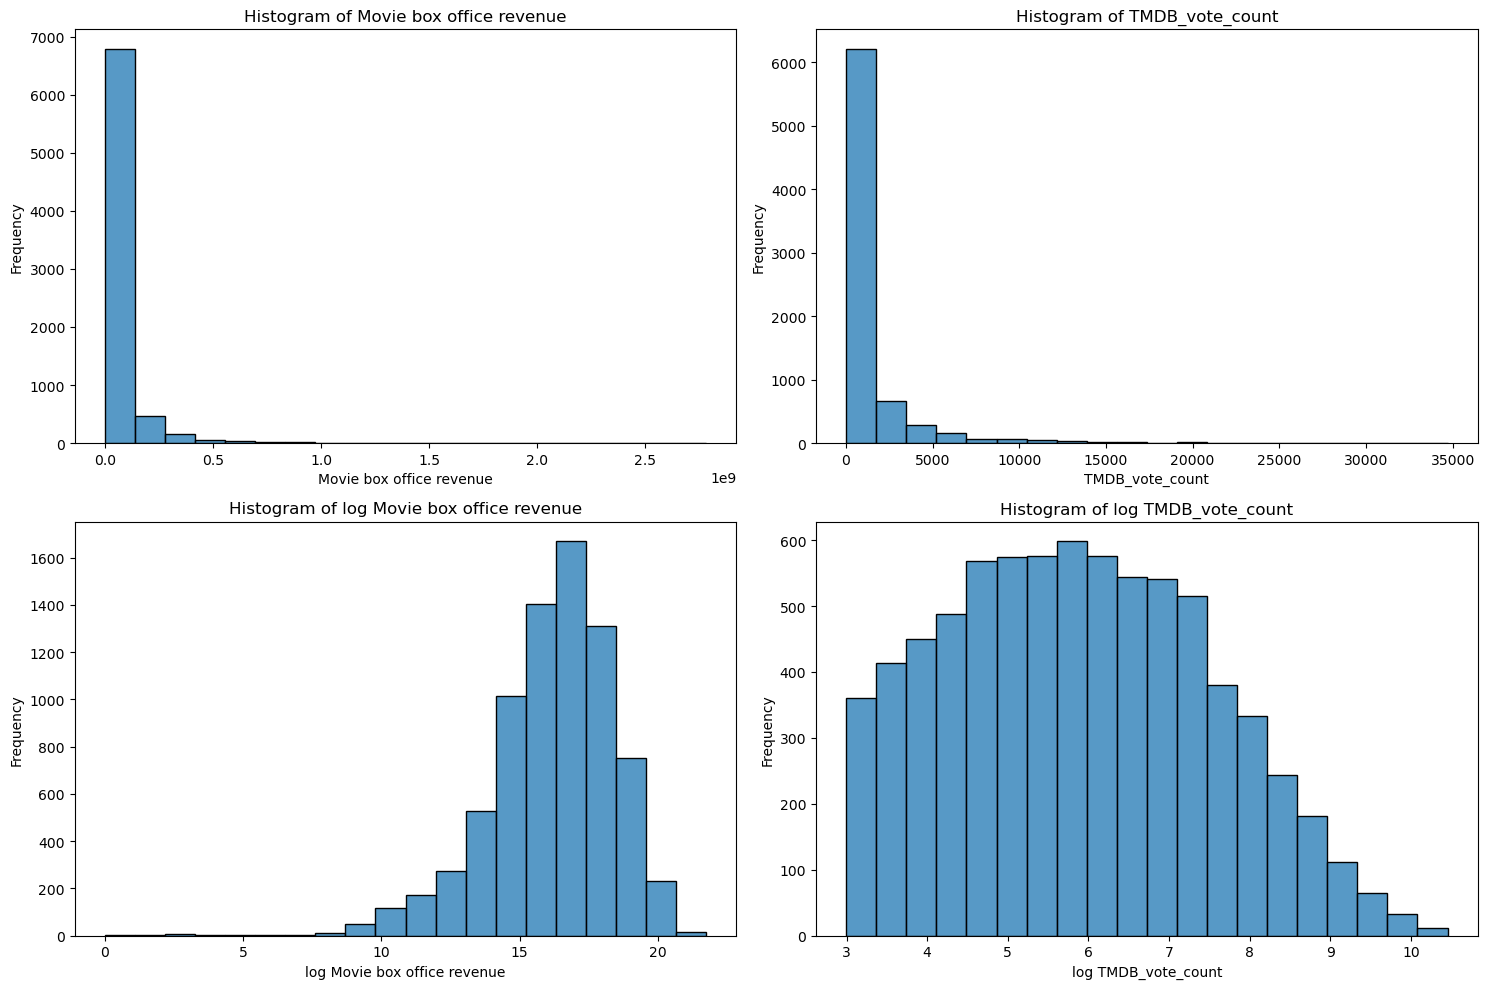

In [27]:
# Original variables
original_variables = ['Movie box office revenue','TMDB_vote_count']

# Log-transformed variables
log_variables = ['log Movie box office revenue', 'log TMDB_vote_count']

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot original variables
for i, variable in enumerate(original_variables):
    ax = axes[0, i]
    sns.histplot(data=movie_metadata, x=variable, ax=ax, bins=20)
    ax.set_xlabel(variable)
    ax.set_ylabel('Frequency')
    ax.set_title('Histogram of ' + variable)

# Plot log-transformed variables
for i, variable in enumerate(log_variables):
    ax = axes[1, i]
    sns.histplot(data=movie_metadata, x=variable, ax=ax, bins=20)
    ax.set_xlabel(variable)
    ax.set_ylabel('Frequency')
    ax.set_title('Histogram of ' + variable)

# Adjust the layout to prevent overlapping
plt.tight_layout()
plt.show()


After the log transform, **Movie box office revenue** and **TMDB_vote_count** is fairly normally distributed.

## Missing values

Let's look at the amount of missing values in our data. For each attribute, the percentage of missing values is calculated.

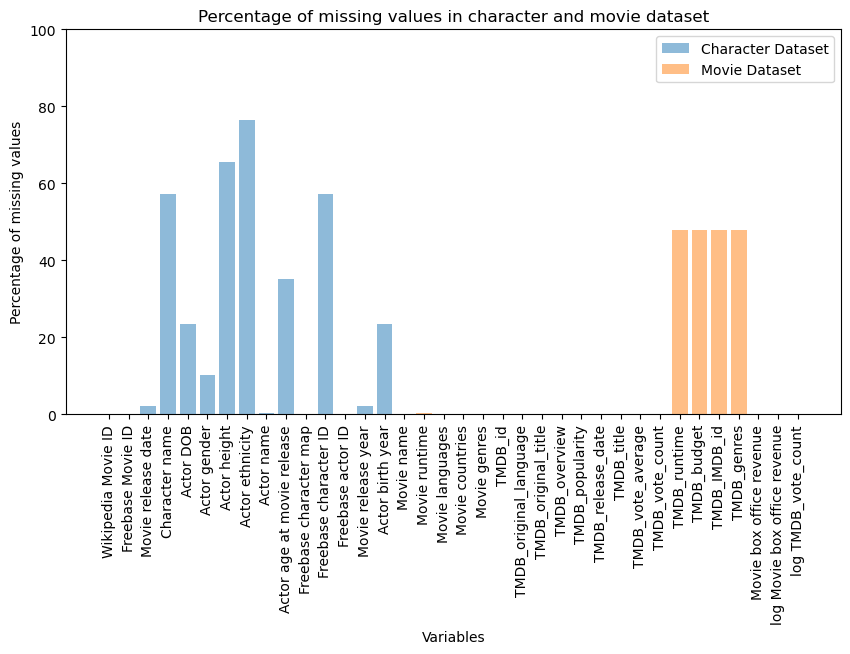

In [28]:
# Calculate percentage of missing values for each attribute
character_nan_percentages = character_metadata.isna().mean() * 100
movie_nan_percentages = movie_metadata.isna().mean() * 100

# Create a bar plot
fig, ax = plt.subplots(figsize=(10, 5))

# Plot the character dataset NaN percentages
ax.bar(character_nan_percentages.index, character_nan_percentages, label='Character Dataset', alpha=0.5)

# Plot the movie dataset NaN percentages
ax.bar(movie_nan_percentages.index, movie_nan_percentages, label='Movie Dataset', alpha=0.5)

ax.set_ylim(0,100)
ax.set_xlabel('Variables')
ax.set_ylabel('Percentage of missing values')
ax.set_title('Percentage of missing values in character and movie dataset')
ax.legend()
plt.xticks(rotation=90)
plt.show()

As we can see, there is a lot of missing values for some of the attributes. Especially **Movie box office revenue** has a lot of missing values (around 90%). We have already enriched the this attribute with more data, but it is still lacking, Despite the amount of missing values, we decide to work with it, since this attribute still has around 10'000 data points.

Some character attributes like height and ethnicity are also missing.

## Distribution of variables after cleaning

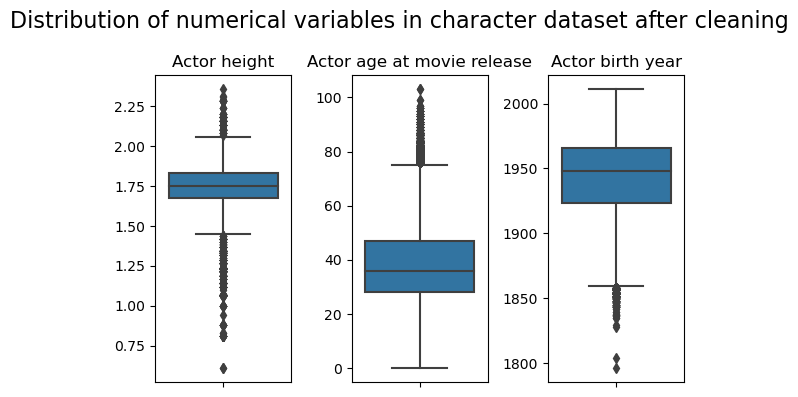

In [29]:
character_metadata_subset = character_metadata[['Actor height', 'Actor age at movie release', 'Actor birth year']]

# Set up subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(6, 4))
fig.suptitle('Distribution of numerical variables in character dataset after cleaning', fontsize=16)

# Flatten the axes for easier indexing
axes = axes.flatten()

# Iterate through each column and create a boxplot in a subplot
for i, column in enumerate(character_metadata_subset.columns):
    sns.boxplot(ax=axes[i], y=character_metadata_subset[column])
    axes[i].set_title(f'{column}')
    axes[i].set_ylabel('')

# Adjust layout
plt.tight_layout()
plt.savefig('figures/dist_and_clean/after_cleaning_character', dpi=1000, bbox_inches='tight')
plt.show()

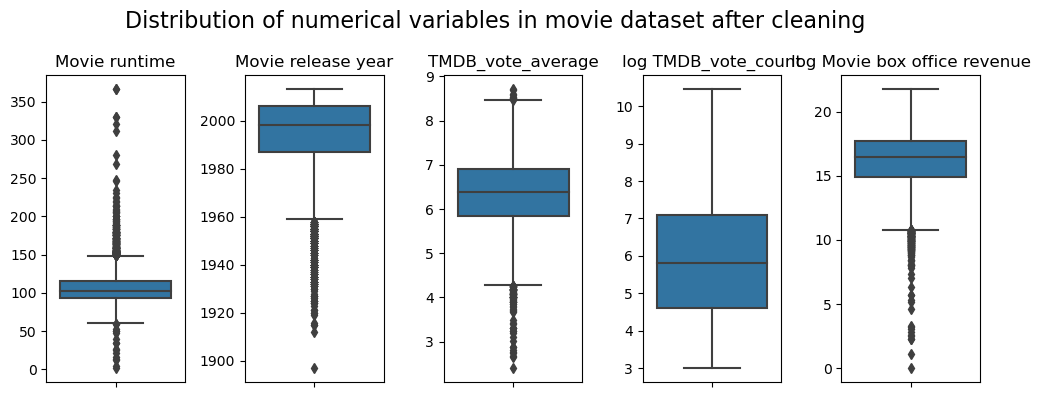

In [30]:
movie_metadata_subset = movie_metadata[['Movie runtime', 'Movie release year', 'TMDB_vote_average','log TMDB_vote_count', 'log Movie box office revenue']]

# Set up subplots
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(10, 4))
fig.suptitle('Distribution of numerical variables in movie dataset after cleaning', fontsize=16)

# Flatten the axes for easier indexing
axes = axes.flatten()

# Iterate through each column and create a boxplot in a subplot
for i, column in enumerate(movie_metadata_subset.columns):
    sns.boxplot(ax=axes[i], y=movie_metadata_subset[column])
    axes[i].set_title(f'{column}')
    axes[i].set_ylabel('')

# Adjust layout
plt.tight_layout()
plt.savefig('figures/dist_and_clean/after_cleaning_movie', dpi=1000, bbox_inches='tight')
plt.show()

### Categorical values

Let us take a look at the categorical values.

In [31]:
movie_metadata[['Movie genres', 'Movie languages', 'Movie countries']].head()

,Movie genres,Movie languages,Movie countries
0,"{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...","{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}"
13,"{""/m/04xvh5"": ""Costume drama"", ""/m/082gq"": ""Wa...","{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}"
17,"{""/m/0hj3myq"": ""Children's/Family"", ""/m/04t36""...","{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}"
29,"{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...","{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}"
47,"{""/m/0vgkd"": ""Black comedy"", ""/m/01z4y"": ""Come...","{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America"", ""/m/..."


We convert all the values for consistency and check all unique values.

In [32]:
# Define categorical variables
categorical_variables = ['Movie genres', 'Movie languages', 'Movie countries']

# Transform categorical_variables to lists of strings
for variable in categorical_variables:
    cleaned_column_name = f"{variable}"
    movie_metadata[cleaned_column_name] = movie_metadata[variable].apply(lambda x: ", ".join(eval(x).values()) if isinstance(eval(x), dict) else "")
    
    # Remove 'Language' or ' language' from entries in the 'Movie languages' column
    if variable == 'Movie languages':
        movie_metadata[cleaned_column_name] = movie_metadata[cleaned_column_name].str.replace(' Language', '').str.replace(' language', '')
    
    # Convert the string representation to a list
    movie_metadata[cleaned_column_name] = movie_metadata[cleaned_column_name].apply(lambda x: x.split(', ') if x else [])


In [33]:
# Find unique original languages
unique_original_languages = movie_metadata['TMDB_original_language'].unique()
print(f"Number of original unique languages: {len(unique_original_languages)}")

display(unique_original_languages)

Number of original unique languages: 37


array(['en', 'es', 'sr', 'ko', 'tr', 'fr', 'hi', 'pt', 'ml', 'it', 'cn',
       'el', 'th', 'zh', 'de', 'ro', 'ru', 'cs', 'ar', 'ja', 'sv', 'da',
       'nl', 'ta', 'fa', 'he', 'fi', 'iu', 'pl', 'mn', 'te', 'hu', 'vi',
       'is', 'bg', 'no', 'tn'], dtype=object)

In [34]:
# Find unique movie languages

# Split the languages and create a new data frame with expanded rows
languages_df = movie_metadata['Movie languages'].explode().reset_index()

# Count the unique languages
unique_languages = languages_df['Movie languages'].unique()
print(f"Number of unique languages: {len(unique_languages)}")

display(unique_languages)

Number of unique languages: 142


array(['English', 'Afrikaans', 'Spanish', 'Romani', 'Italian',
       'Serbo-Croatian', 'Bulgarian', 'Serbian', 'German', 'Korean',
       'French', 'Standard Mandarin', 'Standard Cantonese', 'Turkish',
       'American English', nan, 'Hindi', 'Japanese', 'Malayalam', 'Czech',
       'Slovak', 'Thai', 'Polish', 'Greek', 'Ancient Greek', 'Arabic',
       'Cantonese', 'Hungarian', 'Russian', 'Dutch', 'American Sign',
       'Silent film', 'Romanian', 'Welsh', 'Hebrew', 'Zulu', 'Latin',
       'Portuguese', 'Urdu', 'Mandarin Chinese', 'Chinese', 'Irish',
       'Yiddish', 'Swahili', 'Somali', 'Swedish', 'Navajo', 'Danish',
       'Algonquin', 'Ukrainian', 'Macedonian', 'Aramaic', 'Esperanto',
       'Quechua', 'Maya', 'Yucatán', 'Malay', 'Tamil', 'Vietnamese',
       'Bengali', 'Persian', 'Croatian', 'Scottish Gaelic', 'Catalan',
       'Old English', 'Icelandic', 'Apache', 'Western', 'Finnish',
       'Punjabi', 'Inuktitut', 'Estonian', 'Burmese', 'Armenian',
       'Mongolian', 'Telugu'

## Adding extra columns for exploration

**Percentage of male actors per movie**

In [35]:
#Group character_metadata by 'Wikipedia Movie ID' and calculate the percentage of male/female actors in each movie
male_percentage_per_movie = character_metadata.groupby('Wikipedia Movie ID')['Actor gender'].apply(lambda x: (x == 'M').sum() / len(x) * 100).reset_index()
male_percentage_per_movie.columns = ['Wikipedia Movie ID', 'Male_actor_percentage']

# Merge the male_percentage_per_movie dataframe with movie_metadata on 'Wikipedia Movie ID'
movie_metadata = pd.merge(movie_metadata, male_percentage_per_movie, on='Wikipedia Movie ID', how='left')

**Average age of actors**

In [ ]:
# Group character_metadata by 'Wikipedia Movie ID' and calculate the average birth year of actors in each movie
average_actor_age_per_movie = character_metadata.groupby('Wikipedia Movie ID')['Actor age at movie release'].mean().reset_index()
average_actor_age_per_movie.columns = ['Wikipedia Movie ID', 'Mean_actor_age_at_movie_release']

# Merge the dataframe with movie_metadata on 'Wikipedia Movie ID'
movie_metadata = pd.merge(movie_metadata, average_actor_age_per_movie, on='Wikipedia Movie ID', how='left')

# Remove unrealistic values
condition = (movie_metadata['Mean_actor_age_at_movie_release'] < 1) 
movie_metadata.loc[condition, 'Mean_actor_age_at_movie_release'] = np.nan


# Data wrangling and exploration

## Distribution of variables in the character dataset

We now want to look at the distribution of the attributes of the characters metadata set. We divide the character dataset into male and female character dataset, and use box plots and histograms to look at the distribution on the attributes. We also perform a t-test for each of the attributes with the nul-hypothesis: there is no difference between male and female.

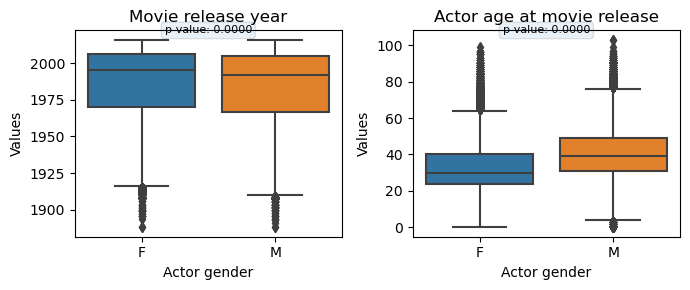

In [ ]:
# Variables of interest
#variables = ['Movie release year', 'Actor birth year', 'Actor height', 'Actor age at movie release']

# Variables of interest
variables = ['Movie release year', 'Actor age at movie release']

# Create a figure with four subplots
fig, axes = plt.subplots(1, 2, figsize=(7, 3))

# Create box plots for each variable in each subplot
for i, variable in enumerate(variables):
    ax = axes[i]

    # Use sns.boxplot with 'Actor gender' as 'hue'
    sns.boxplot(x='Actor gender', y=variable, data=character_metadata, ax=ax)

    # Perform a t-test and get the p-value
    female_data = character_metadata[character_metadata['Actor gender'] == 'F'][variable].dropna()
    male_data = character_metadata[character_metadata['Actor gender'] == 'M'][variable].dropna()
    t_stat, p_value = stats.ttest_ind(female_data, male_data)

    # Annotate the plot with the p-value
    ax.annotate(f'p-value: {p_value:.4f}', xy=(0.5, max(ax.get_ylim())), ha='center', va='center',
                bbox=dict(boxstyle="round", alpha=0.1),
                fontsize=8, color='black')

    ax.set_ylabel('Values')
    ax.set_title(variable)

# Adjust the layout to prevent overlapping
plt.tight_layout()
plt.savefig('figures/gender/boxplots.png', dpi=1000, bbox_inches='tight')
plt.show()


The first box plots show us, that more movies have been released in the more revent years. Naturally, the birth years of the actor are also more recent therefore. These also show us, that there is a significant difference in **Movie release year** and **Actor birth year** for male and female actors, where female actors are more represented in recent years. We might want to log-transform these attributes, if they are used in further analysis.

The height attribute shows that there is significant difference between the height of male and female, which makes sense, since men are naturally taller than woman.

The last box plot shows us, that there is a significant difference in the **Actor age at movie release** for male and female actors. It indicates, that female actors generally are younger than male actors in movies.

We also look at the distributions with a histogram:

### Explore **Actor age at movie release**

To explore the statistical difference further, we look at the attribute **Actor age at movie release** throughout all the years for female and male characters.

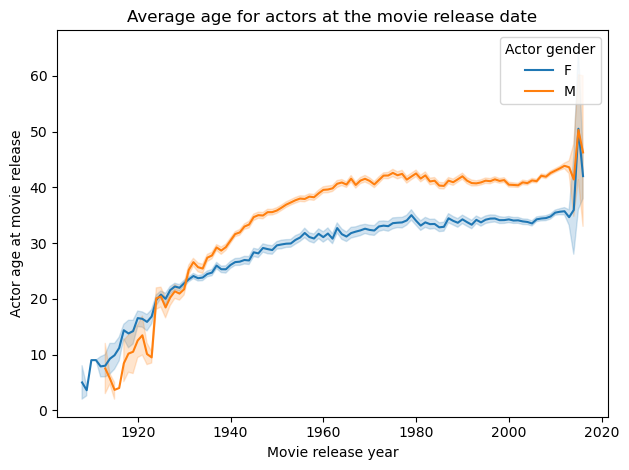

In [ ]:
# Remove NaNs from relevant columns
character_metadata_nona = character_metadata[['Movie release year', 'Actor age at movie release', 'Actor gender']].dropna()
sns.lineplot(x='Movie release year', y='Actor age at movie release', data=character_metadata_nona, hue="Actor gender", err_style="band")

plt.title('Average age for actors at the movie release date')
plt.xlabel('Movie release year')
plt.ylabel('Actor age at movie release')
plt.tight_layout()
plt.savefig('figures/gender/gender_age.png', dpi=1000, bbox_inches='tight')
plt.show()


The plot is very strange up until around 1930. It seems that actors are very young (20 years or younger on average).

However, the plot shows that female actors are significantly younger than male actors from around year 1930 and forward.

In [ ]:
# We add Movie box office revenue to the character dataset
character_metadata_with_rev = character_metadata.merge(movie_metadata[['Wikipedia Movie ID', 'Movie box office revenue', 'log Movie box office revenue']], 
                                                      how='inner', 
                                                      on='Wikipedia Movie ID')

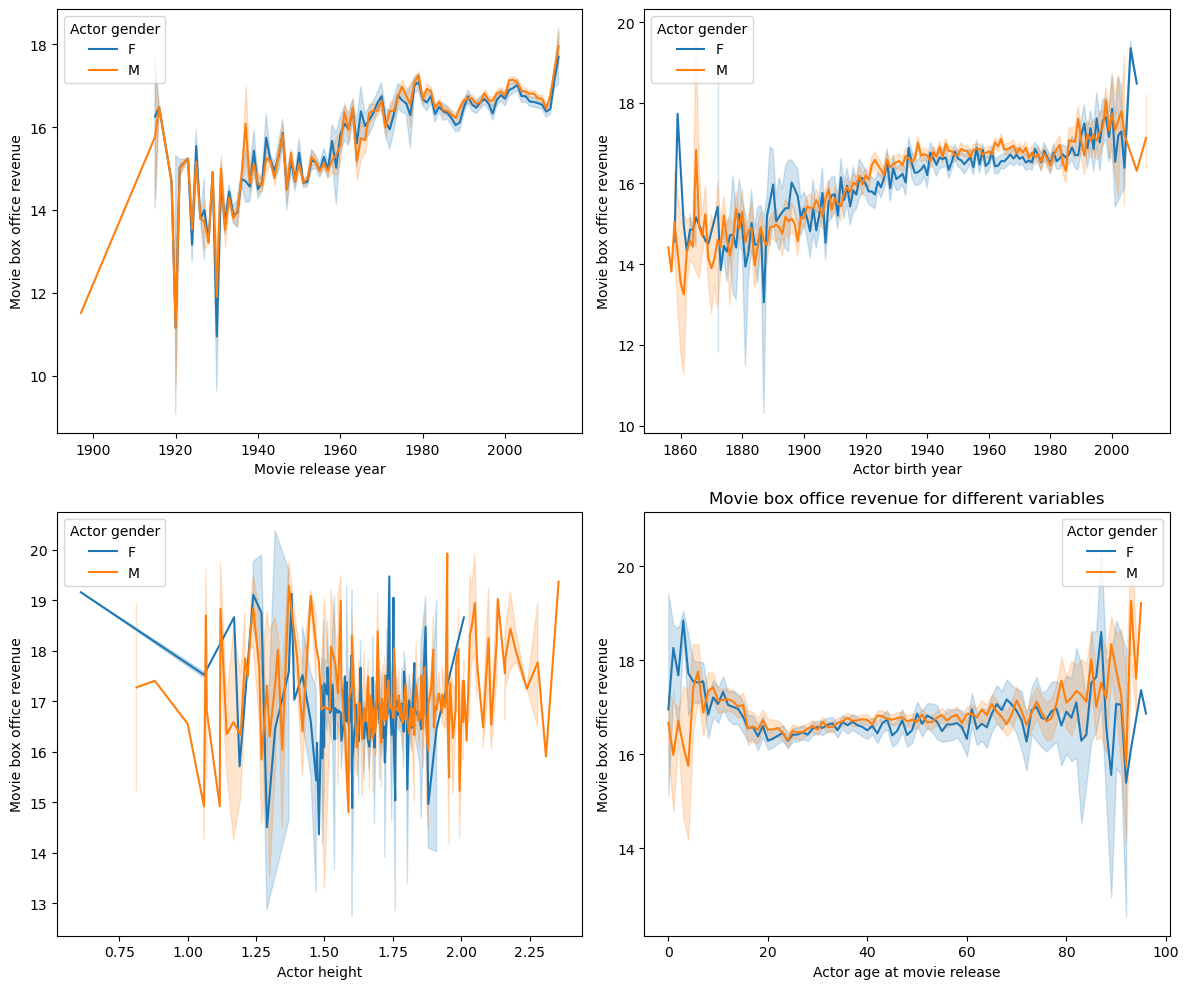

In [ ]:

# Variables of interest
variables = ['Movie release year', 'Actor birth year', 'Actor height', 'Actor age at movie release']

# Create four subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Create line plots for each variable in each subplot
for i, variable in enumerate(variables):
    ax = axes[i]

    # Filter data and drop missing values
    #data_variable = character_metadata[['Movie release year', 'Actor age at movie release', 'Actor gender', variable]].dropna()

    # Use sns.lineplot with 'Actor gender' as 'hue'
    sns.lineplot(data=character_metadata_with_rev, x=variable, y='log Movie box office revenue', hue="Actor gender", err_style="band", ax=ax)

    ax.set_ylabel('Movie box office revenue')
    ax.set_xlabel(variable)
    ax.legend(title='Actor gender')

# Adjust the layout to prevent overlapping
plt.title('Movie box office revenue for different variables')
plt.tight_layout()
plt.show()

There seems to be no significance difference between male and female actors, since all confidence intervals overlap.

## Inflation
Let's check, if the inflation rate has changed significantly.

In [ ]:
subset_rev_year = movie_metadata[['Movie release year', "log Movie box office revenue"]].dropna()

# Perform linear regression
X = subset_rev_year['Movie release year']
X = sm.add_constant(X)  # Add an intercept term
y = subset_rev_year["log Movie box office revenue"]

model = sm.OLS(y, X).fit()

# Print the regression summary
print(model.summary())


                                 OLS Regression Results                                 
Dep. Variable:     log Movie box office revenue   R-squared:                       0.026
Model:                                      OLS   Adj. R-squared:                  0.026
Method:                           Least Squares   F-statistic:                     203.1
Date:                          Wed, 20 Dec 2023   Prob (F-statistic):           1.70e-45
Time:                                  13:10:20   Log-Likelihood:                -16691.
No. Observations:                          7563   AIC:                         3.339e+04
Df Residuals:                              7561   BIC:                         3.340e+04
Df Model:                                     1                                         
Covariance Type:                      nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
-----------------------

Since the value of the US dollar is not the same now as it was in 1800, we have to take inflation into account. Therefore we import a dataset containing the value of the dollar from 1800 to 2023 relative to the value in 1800. We divide **Movie box office revenue** with the inflation rate for each year. Finally we log transform getting the attribute **log balanced Movie box office revenue**.

In [ ]:
inflation_data = pd.read_csv('data/inflation_data.csv')
inflation_data.rename(columns={'year': 'Movie release year'}, inplace=True)

movie_metadata_inflation = movie_metadata.merge(inflation_data[['Movie release year', 'amount']], how='left', on='Movie release year')
movie_metadata_inflation.rename(columns={'amount': 'Dollar value'}, inplace=True)

movie_metadata['balanced Movie box office revenue'] = (movie_metadata_inflation['Movie box office revenue']) / (movie_metadata_inflation['Dollar value'])
movie_metadata['log balanced Movie box office revenue'] = np.log10((movie_metadata['balanced Movie box office revenue']))


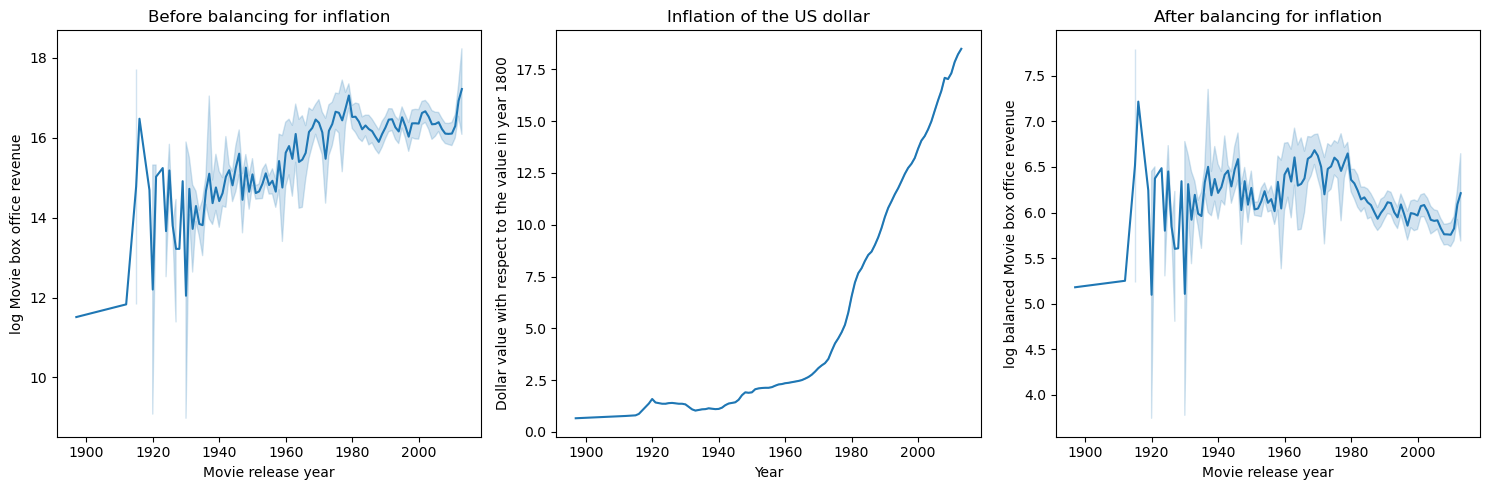

In [ ]:
# Set up subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# First subplot - log Movie box office revenue trend
sns.lineplot(data=movie_metadata, x='Movie release year', y='log Movie box office revenue', ax=axes[0])
#sns.regplot(data=movie_metadata, x='Movie release year', y='log Movie box office revenue', scatter=False, ax=axes[0])
axes[0].set_title('Before balancing for inflation')
axes[0].set_xlabel('Movie release year')
axes[0].set_ylabel('log Movie box office revenue')

# Second subplot - Inflation of the dollar
sns.lineplot(data=movie_metadata_inflation, x='Movie release year', y='Dollar value', ax=axes[1])
axes[1].set_title('Inflation of the US dollar')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Dollar value with respect to the value in year 1800')

sns.lineplot(data=movie_metadata, x='Movie release year', y='log balanced Movie box office revenue', ax=axes[2])
#sns.regplot(data=movie_metadata, x='Movie release year', y='log balanced Movie box office revenue', scatter=False, ax=axes[2])
axes[2].set_title('After balancing for inflation')
axes[2].set_xlabel('Movie release year')
axes[2].set_ylabel('log balanced Movie box office revenue')

# Adjust layout
plt.tight_layout()

# Save the entire figure
plt.savefig("figures/dist_and_clean/inflation_plots.png", dpi=1000, bbox_inches='tight')

# Show the plots
plt.show()

In [ ]:
subset_rev_year_balanced = movie_metadata[['Movie release year', "log balanced Movie box office revenue"]].dropna()

# Perform linear regression
X = subset_rev_year_balanced['Movie release year']
X = sm.add_constant(X)  # Add an intercept term
y = subset_rev_year_balanced["log balanced Movie box office revenue"]

model = sm.OLS(y, X).fit()

# Print the regression summary
print(model.summary())

                                      OLS Regression Results                                     
Dep. Variable:     log balanced Movie box office revenue   R-squared:                       0.019
Model:                                               OLS   Adj. R-squared:                  0.019
Method:                                    Least Squares   F-statistic:                     145.6
Date:                                   Wed, 20 Dec 2023   Prob (F-statistic):           3.19e-33
Time:                                           13:10:32   Log-Likelihood:                -10388.
No. Observations:                                   7563   AIC:                         2.078e+04
Df Residuals:                                       7561   BIC:                         2.079e+04
Df Model:                                              1                                         
Covariance Type:                               nonrobust                                         
                    

After balancing for inflation, there seems to be a negative trend (Movie box office revenues are declining).

We will now save the cleaned dataset and keep working with this.

In [ ]:
# Save cleaned data sets
movie_metadata.to_csv('data_cleaned/movie_cleaned.csv')
character_metadata.to_csv('data_cleaned/character_cleaned.csv')

# Further exploration



## Runtimes effect


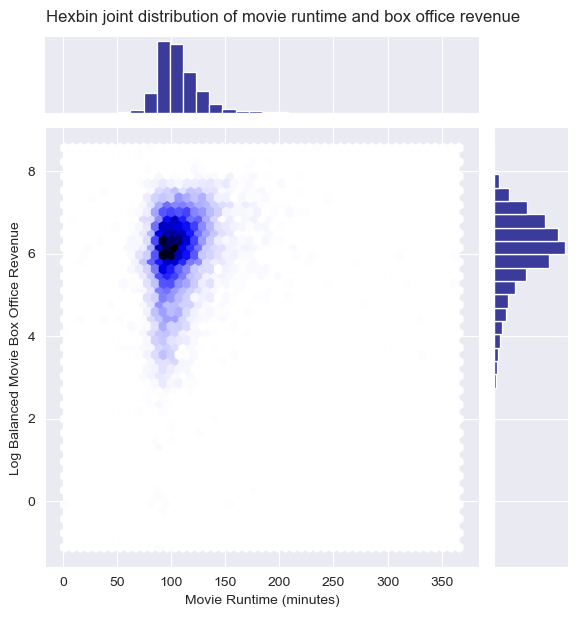

In [ ]:
    # Generate the hexbin plot with marginal histograms
sns.jointplot(
    data=movie_metadata,
    x="Movie_runtime",
    y="log_balanced_Movie_box_office_revenue",
    kind="hex",
    color="navy",
    marginal_kws=dict(bins=30, fill=True)
)

# Set labels and title
plt.xlabel('Movie Runtime (minutes)')
plt.ylabel('Log Balanced Movie Box Office Revenue')
plt.suptitle('Hexbin joint distribution of movie runtime and box office revenue', y=1.02)

# Show the plot
plt.savefig(dpi=1000,fname='movie_runtimeVSlogbalanced_movieboxofficerevenue')
plt.show()

## Gender representation in movie

We now want to further analyse our data by exploring the difference in representation of female and male actors in movies. We begin by counting the number of female and male actor in movies throughout the year


In [ ]:
# Load cleaned datasets
movie_metadata = pd.read_csv('data_cleaned/movie_cleaned.csv', lineterminator='\n')
character_metadata = pd.read_csv('data_cleaned/character_cleaned.csv')

In [ ]:
# Divide data set into male and female data set

female_characters = character_metadata[character_metadata['Actor gender'] == 'F']
male_characters = character_metadata[character_metadata['Actor gender'] == 'M']

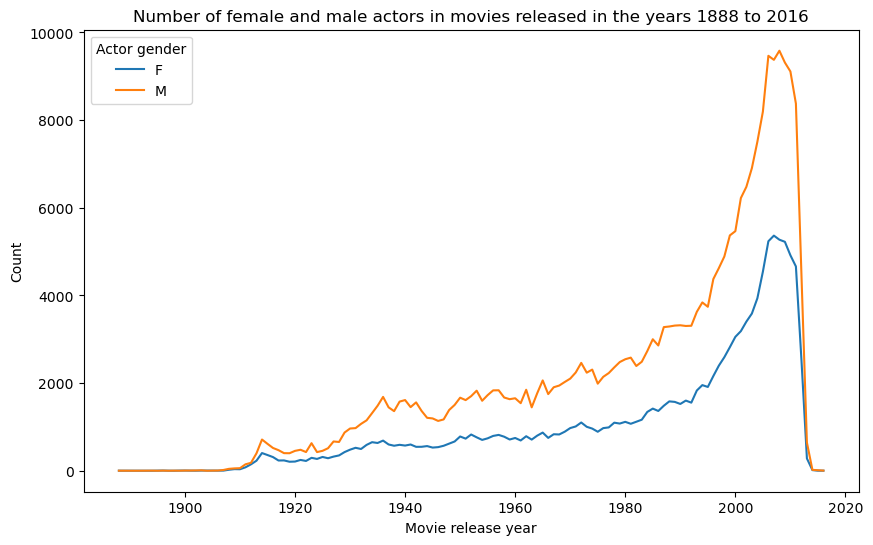

In [ ]:
gender_counts = character_metadata.groupby(['Movie release year', 'Actor gender']).size().reset_index(name='Count')
 
# Plot using Seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(data=gender_counts, x='Movie release year', y='Count', hue='Actor gender')
plt.title('Number of female and male actors in movies released in the years 1888 to 2016')
plt.xlabel('Movie release year')
plt.ylabel('Count')
plt.legend(title='Actor gender')
plt.savefig("figures/gender/gender_count_release_year.png", dpi=1000, bbox_inches='tight')
plt.show()

As we can see, there are generally fewer female actors in movies than male actors.

Next, we will explore the percentage of female characters in movies throughout the years. Firstly, we calculate the percentage of females for each movie and then take the average over each year. We then make a linear regression to see, if there is a change of percentage of female actors in movies over the years.

/Users/bruger/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


                                 OLS Regression Results                                 
Dep. Variable:     Percentage female characters   R-squared:                       0.028
Model:                                      OLS   Adj. R-squared:                  0.018
Method:                           Least Squares   F-statistic:                     2.725
Date:                          Wed, 20 Dec 2023   Prob (F-statistic):              0.102
Time:                                  13:10:41   Log-Likelihood:                -271.17
No. Observations:                            96   AIC:                             546.3
Df Residuals:                                94   BIC:                             551.5
Df Model:                                     1                                         
Covariance Type:                      nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
-----------------------

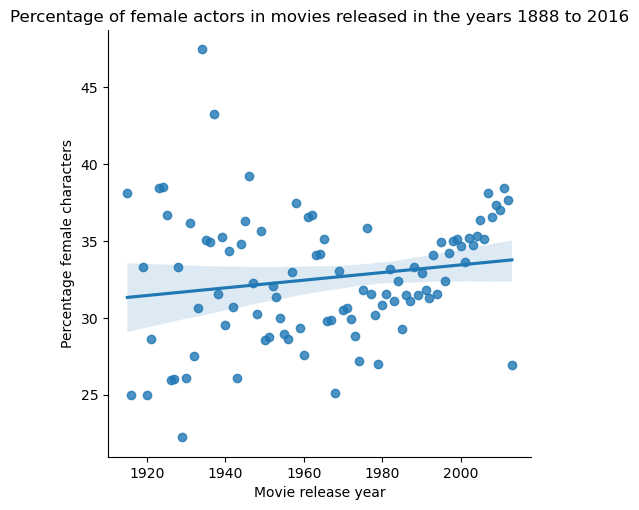

In [ ]:
# Count number of female in each movie
female_count = female_characters.groupby('Wikipedia Movie ID').size()
male_count = male_characters.groupby('Wikipedia Movie ID').size()

# Ensure that all Wikipedia Movie IDs in 'female_count' are represented in 'male_count'
# Fill missing values with 0
male_count = male_count.reindex(female_count.index, fill_value=0)

# Calculate the percentage of female characters
percentage_female = (female_count / (female_count + male_count)) * 100

# Reset the index to have 'Wikipedia Movie ID' as a column
percentage_female = percentage_female.reset_index()

# Rename the columns for clarity
percentage_female.columns = ['Wikipedia Movie ID', 'Percentage female characters']

# Merge dataframes
percentage_female_with_year = pd.merge(percentage_female, movie_metadata, on='Wikipedia Movie ID', how='left')

# Calculate female percentage pr. year and make into a data frame with column 'Movie release year' and 'Percentage female characters'
percentage_female_per_year = percentage_female_with_year.groupby('Movie release year')['Percentage female characters'].mean()
percentage_female_per_year = percentage_female_per_year.reset_index(name="Percentage female characters")
percentage_female_per_year['Movie release year'] = pd.to_numeric(percentage_female_per_year['Movie release year'], errors='coerce').astype(float)

# Drop missing values
percentage_female_per_year = percentage_female_per_year.dropna()

sns.lmplot(x='Movie release year', y="Percentage female characters", data=percentage_female_per_year)

# Perform linear regression
X = percentage_female_per_year['Movie release year']
X = sm.add_constant(X)  # Add an intercept term
y = percentage_female_per_year["Percentage female characters"]

model = sm.OLS(y, X).fit()

# Print the regression summary
print(model.summary())

plt.title('Percentage of female actors in movies released in the years 1888 to 2016')
plt.savefig("figures/gender/female_percentage_release_year.png", dpi=1000, bbox_inches='tight')
plt.show()

The plot and linear regression indicates, that there is a significant no significant change of female characters over the years. But looking at the plot, there seems to be a trend from 1980 and forward. Let us look at that.

/Users/bruger/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


                                 OLS Regression Results                                 
Dep. Variable:     Percentage female characters   R-squared:                       0.397
Model:                                      OLS   Adj. R-squared:                  0.378
Method:                           Least Squares   F-statistic:                     21.04
Date:                          Wed, 20 Dec 2023   Prob (F-statistic):           6.58e-05
Time:                                  13:10:45   Log-Likelihood:                -72.294
No. Observations:                            34   AIC:                             148.6
Df Residuals:                                32   BIC:                             151.6
Df Model:                                     1                                         
Covariance Type:                      nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
-----------------------

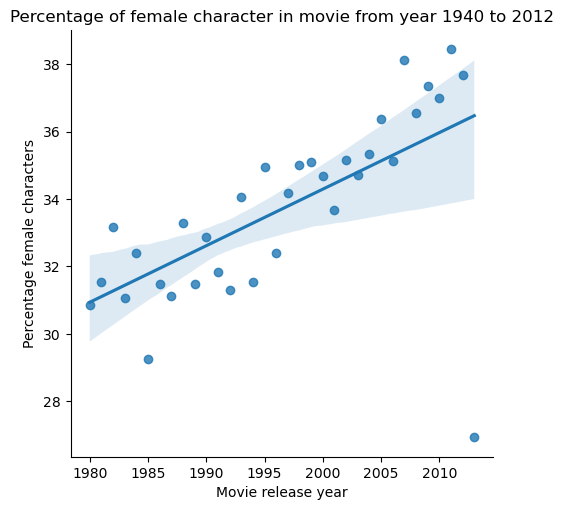

In [ ]:
condition = (percentage_female_per_year['Movie release year'] < 1980)
percentage_female_per_year_filtered = percentage_female_per_year
percentage_female_per_year_filtered.loc[condition, 'Movie release year'] = np.nan
percentage_female_per_year_filtered = percentage_female_per_year_filtered.dropna()

sns.lmplot(x='Movie release year', y="Percentage female characters", data=percentage_female_per_year_filtered)

# Perform linear regression
X = percentage_female_per_year_filtered['Movie release year']
X = sm.add_constant(X)  # Add an intercept term
y = percentage_female_per_year_filtered["Percentage female characters"]

model = sm.OLS(y, X).fit()

# Print the regression summary
print(model.summary())

plt.title('Percentage of female character in movie from year 1940 to 2012')
plt.savefig("figures/gender/female_percentage_release_year_filtered.png", dpi=1000, bbox_inches='tight')
plt.show()

This regression shows, that there is a significant increase in percentage of female actors from year 1980 and forward.

### Gender's affect on box office revenue

We will now see if percentage of female characters have a significant correlation with **Movie box office revenue**.

                                      OLS Regression Results                                     
Dep. Variable:     log balanced Movie box office revenue   R-squared:                       0.018
Model:                                               OLS   Adj. R-squared:                  0.018
Method:                                    Least Squares   F-statistic:                     130.9
Date:                                   Wed, 20 Dec 2023   Prob (F-statistic):           4.65e-30
Time:                                           13:10:53   Log-Likelihood:                -9743.4
No. Observations:                                   7183   AIC:                         1.949e+04
Df Residuals:                                       7181   BIC:                         1.950e+04
Df Model:                                              1                                         
Covariance Type:                               nonrobust                                         
                    

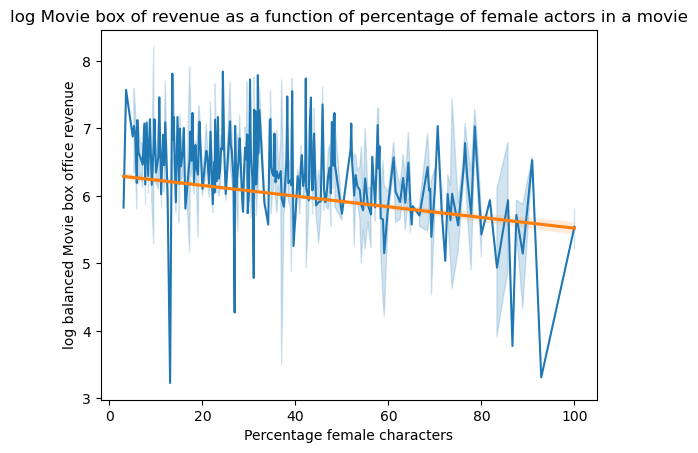

In [ ]:
# Define dataframe with 'log Movie box office revenue' and 'Percentage female characters'
percentage_female_with_log_rev = percentage_female_with_year[['log balanced Movie box office revenue', 'Percentage female characters']].dropna()

# Create a line plot
sns.lineplot(data=percentage_female_with_log_rev, x='Percentage female characters', y='log balanced Movie box office revenue')

# Add a trend line using regplot
sns.regplot(data=percentage_female_with_log_rev, x='Percentage female characters', y='log balanced Movie box office revenue', scatter=False)

# Perform linear regression
X = percentage_female_with_log_rev["Percentage female characters"]
X = sm.add_constant(X)  # Add an intercept term
y = percentage_female_with_log_rev["log balanced Movie box office revenue"]

model = sm.OLS(y, X).fit()

# Print the regression summary
print(model.summary())

plt.title('log Movie box of revenue as a function of percentage of female actors in a movie')
plt.savefig('figures/gender/female_percentage_revenue.png', dpi=1000, bbox_inches='tight')
plt.show()


The plot and linear regression indicates, that there is a significant decline in box office revenue, as the percentage of female characters increases.